# Jet Tagging with Graph Neural Networks (GNN)

This notebook shows how to use a GNN for jet classification between QCD and TT jets using particle-level features represented as a graph. Note that you get some GPU time on Kaggle for free (30 hrs/week). This will make training the model here faster, but note that it won't help you with the graph building, which also does take time here. Sadly you can't turn it on just to run the training, the notebook session must be run as either CPU or GPU. If you want to experiment with GNNs and the graph building becomes annoying, just save the graphs, and then load them as you need. 

## What is a GNN?
A Graph Neural Network (GNN) is a type of neural network designed to process graph-structured data. It can learn from both node features and the graph structure. It can be used to predict information about nodes, links between nodes or graphs as a whole. 

## Why use GNNs for Jet Tagging?
- Very flexible, can start from images or dataframes, or use both 
- Has the potential to remove areas where there is no energy deposited
- Has the potential to include long range interactions in a way a CNN can't 
- Can handle variable number of particles

In [1]:
# this might require you to validate your kaggle account 
# if you don't want that, use binderhub 
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.4 MB/s eta 0:00:00


In [2]:
!pip install awkward
!pip install hist
!pip install mplhep
!pip install numpy
!pip install matplotlib   

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.8/886.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.8/638.8 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 69.2 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hist
import mplhep as hep

hep.style.use("CMS")

# Load labels and feature data
labels = np.load("/kaggle/input/qcd-tt-jet-tagging-co-da-s-hep/train/labels/labels.npy")
features_df = pd.read_csv("/kaggle/input/qcd-tt-jet-tagging-co-da-s-hep/train/features/cluster_features.csv")  # adjust path

# Add labels to the DataFrame
features_df["label"] = labels

# Split by label: 0 = QCD, 1 = TTbar
data = {
    "QCD": features_df[features_df["label"] == 0],
    "TTbar": features_df[features_df["label"] == 1]
}

def plot_variable(varname, xlabel, sigma_range=3):
    fig, ax = plt.subplots()

    # Combine values from both classes and filter NaNs
    combined_values = np.concatenate([
        data["QCD"][varname].dropna().to_numpy(),
        data["TTbar"][varname].dropna().to_numpy()
    ])

    if combined_values.size == 0:
        print(f"[WARNING] Skipping {varname} due to no valid data.")
        return

    # Get bin count from feature map
    bin_count = features[varname][1]

    # Mean and std from combined data
    mean = np.mean(combined_values)
    std = np.std(combined_values)

    # Define x-range based on µ ± N·σ
    x_min = np.min(combined_values) #max(np.min(combined_values), mean - sigma_range * std)
    x_max = np.max(combined_values)#min(np.max(combined_values), mean + sigma_range * std)

    # Bin edges using specified bin count
    filtered_values = combined_values[(combined_values >= x_min) & (combined_values <= x_max)]
    bin_edges = np.histogram_bin_edges(filtered_values, bins=bin_count, range=(x_min, x_max))

    # Histogram
    h = hist.Hist(hist.axis.Variable(bin_edges, name=varname, label=xlabel))
    max_y = 0

    colors = {"QCD": "tab:blue", "TTbar": "tab:orange"}

    for label, df in data.items():
        values = df[varname].dropna().to_numpy()
        values = values[(values >= x_min) & (values <= x_max)]

        mean_val = np.mean(values)
        std_val = np.std(values)
        entries = len(values)

        weights = np.ones_like(values) / entries if entries > 0 else np.ones_like(values)
        h.fill(**{varname: values}, weight=weights)

        hep.histplot(
            h,
            label=f"{label} (μ={mean_val:.2f}, σ={std_val:.2f}, N={entries})",
            ax=ax,
            histtype="fill",
            alpha=0.5,
            color=colors[label]
        )

        max_y = max(max_y, np.max(h.values()))
        h.reset()

    # Set xticks at bin edges and only label clean numbers
    ax.set_xticks(bin_edges)
    xtick_labels = [f"{tick:.2f}" for tick in bin_edges]
    ax.set_xticklabels(xtick_labels, rotation=45)

    ax.set_xlabel(xlabel)
    ax.set_ylabel("Normalized Events")
    ax.set_xlim(bin_edges[0], bin_edges[-1])
    ax.set_ylim(0, max_y * 1.1)
    ax.legend()
    ax.set_title(f"{xlabel} (QCD vs TTbar)")
    plt.tight_layout()
    plt.show()


# Feature label map
features = {
    "n_clusters": ("# clusters per jet", 10),
    "total_pt": ("Total cluster pT", 20),
    "max_cluster_pt": ("Max cluster pT", 2),
    "mean_cluster_pt": ("Mean cluster pT", 10),
    "std_cluster_pt": ("Std dev of cluster pT", 10),
    "max_cluster_size": ("Max cluster size", 20),
    "mean_cluster_size": ("Mean cluster size", 10),
    "std_cluster_size": ("Std dev of cluster size", 10),
    "max_cluster_eta": ("Max eta of clusters", 10),
    "mean_cluster_eta": ("Mean eta of clusters", 4),
    "max_cluster_phi": ("Max phi of clusters", 10),
    "mean_cluster_phi": ("Mean phi of clusters", 4),
    "cluster_pt_ratio": ("Leading/subleading cluster pT ratio", 2),
    "cluster_size_ratio": ("Leading/subleading cluster size ratio", 2)
}

In [4]:
features_df

,n_clusters,max_cluster_pt,mean_cluster_pt,std_cluster_pt,max_cluster_size,mean_cluster_size,std_cluster_size,total_pt,max_cluster_eta,max_cluster_phi,mean_cluster_eta,mean_cluster_phi,cluster_pt_ratio,cluster_size_ratio,label
0,13,2.0,0.615318,0.539951,2,2.0,0.0,7.999129,0.5,0.7,0.076923,0.346154,1.470200,1.0,0.0
1,10,2.0,0.777020,0.601157,2,2.0,0.0,7.770204,0.2,0.5,0.100000,0.230000,1.430785,1.0,0.0
2,4,2.0,0.972718,0.606990,2,2.0,0.0,3.890871,0.1,0.1,0.050000,0.050000,2.557882,1.0,0.0
3,14,2.0,0.746367,0.485636,2,2.0,0.0,10.449135,0.5,0.5,0.185714,0.285714,1.624096,1.0,1.0
4,6,2.0,0.575760,0.639069,2,2.0,0.0,3.454561,0.1,0.1,0.050000,0.066667,4.988196,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3515,11,2.0,0.721241,0.580598,2,2.0,0.0,7.933646,0.2,0.9,0.063636,0.481818,1.202968,1.0,1.0
3516,2,2.0,1.159625,0.840375,2,2.0,0.0,2.319249,0.1,0.1,0.050000,0.050000,6.264701,1.0,0.0
3517,5,2.0,0.804492,0.635988,2,2.0,0.0,4.022461,0.1,0.1,0.060000,0.040000,2.295435,1.0,0.0
3518,6,2.0,0.766277,0.713626,2,2.0,0.0,4.597664,0.1,0.5,0.050000,0.350000,1.327499,1.0,1.0


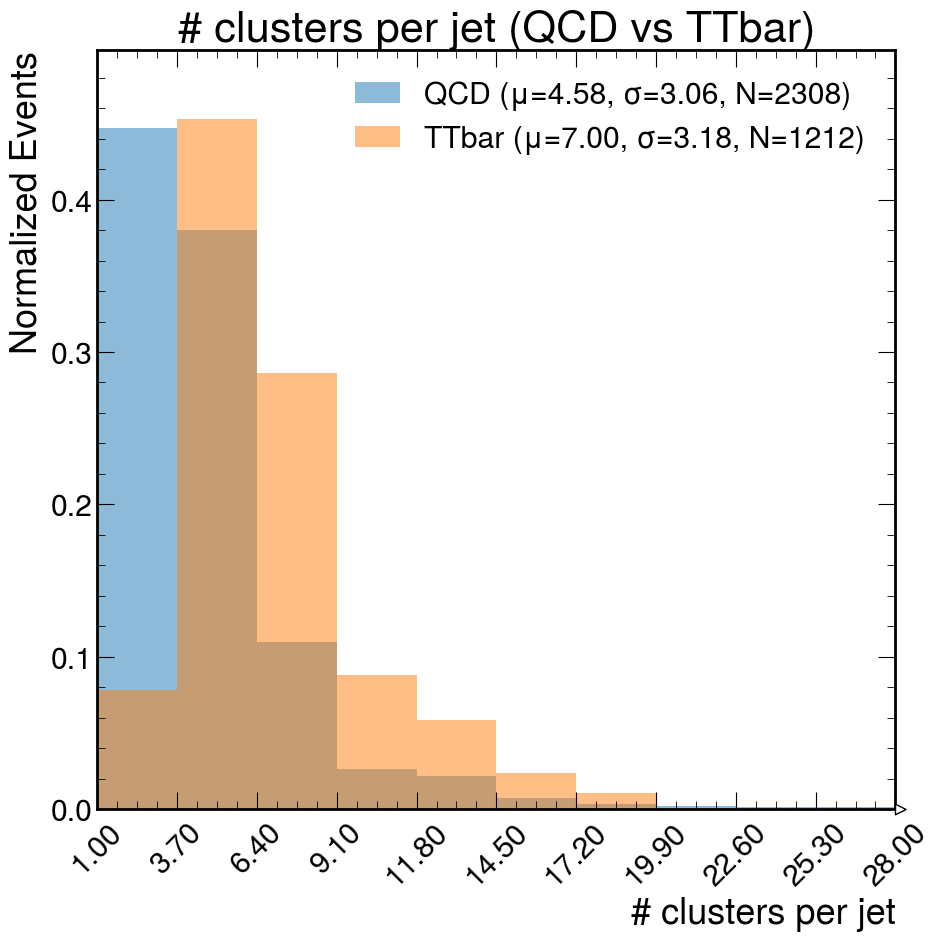

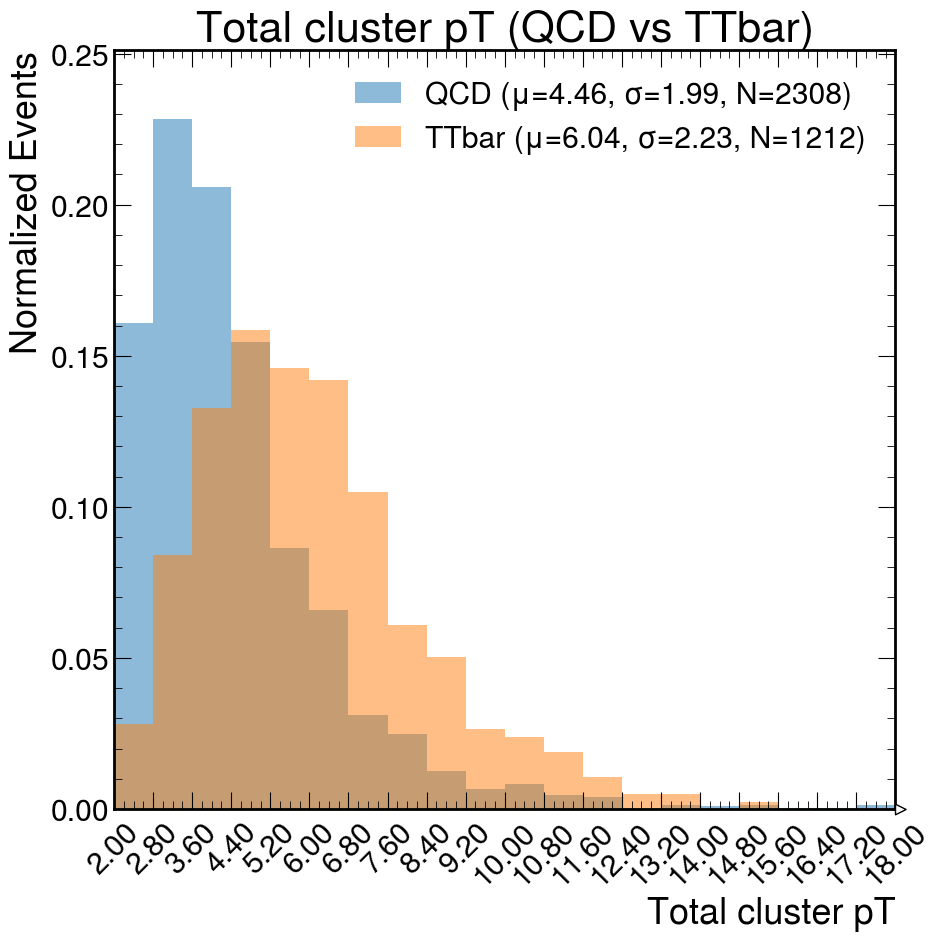

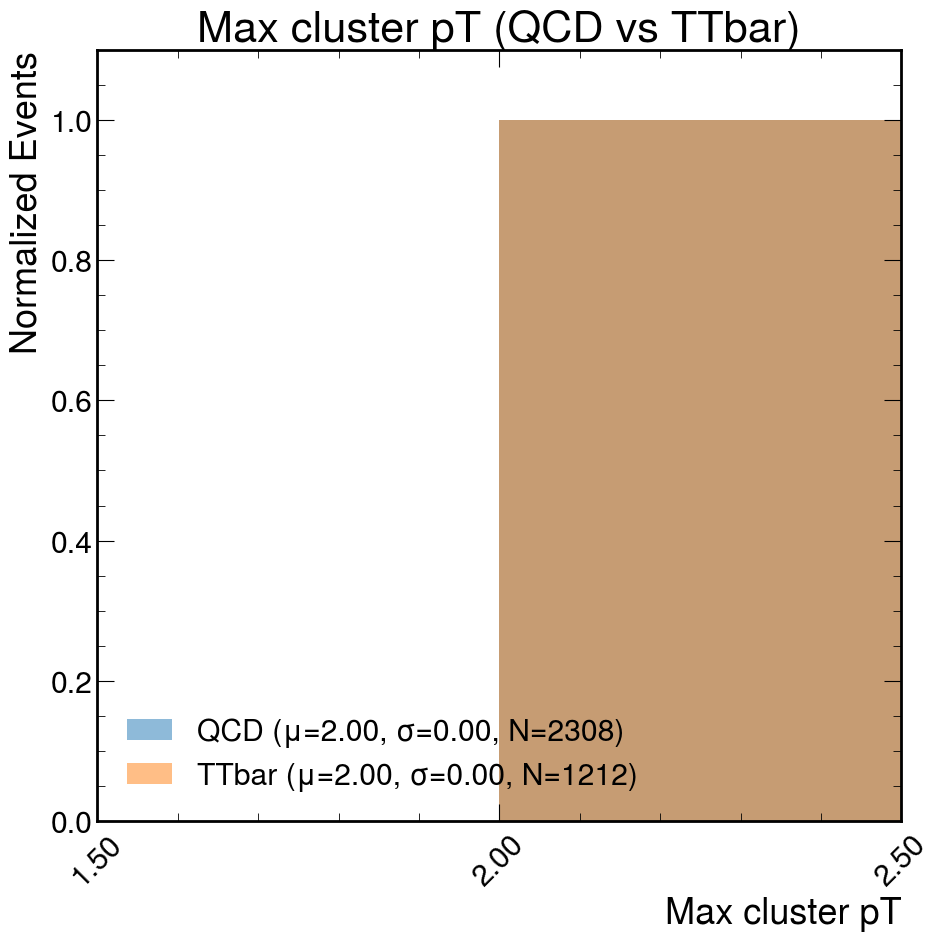

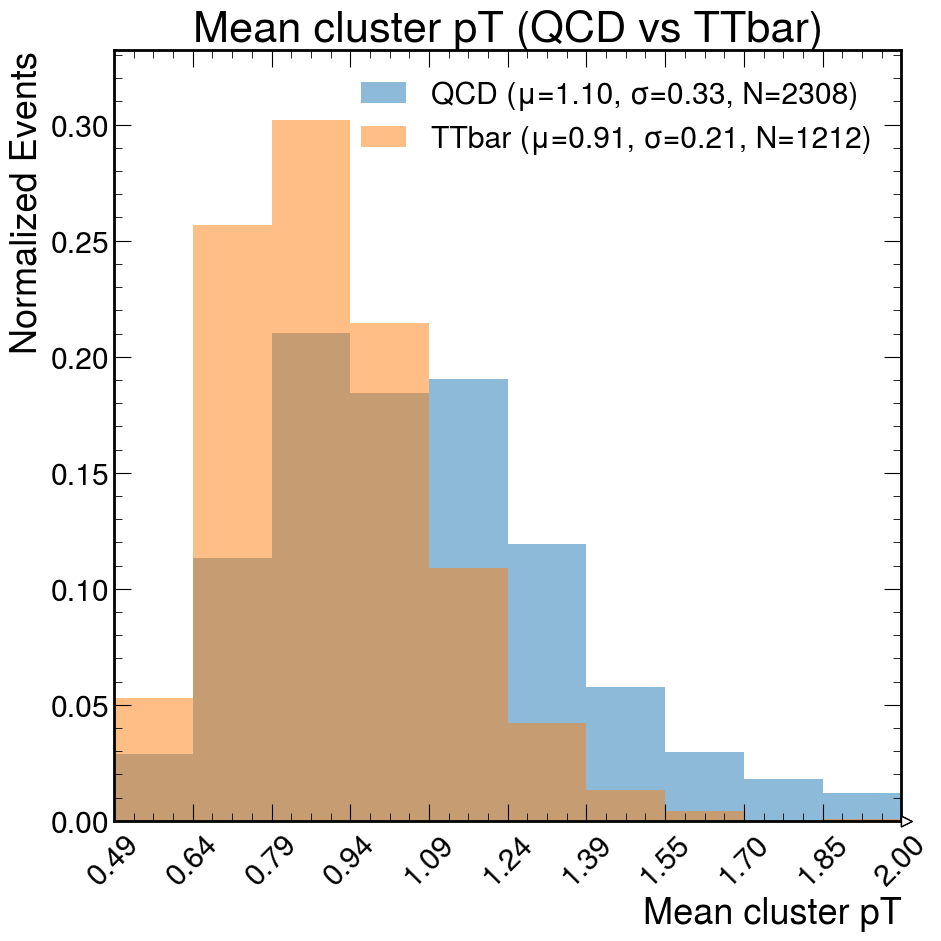

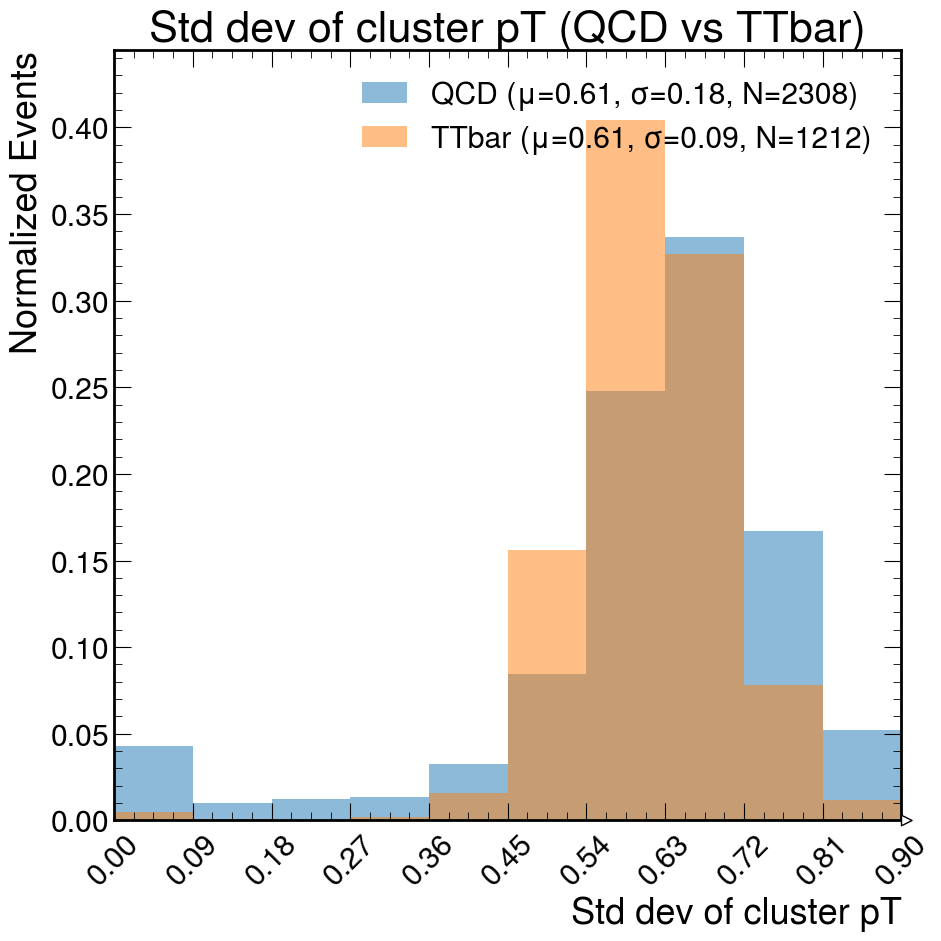

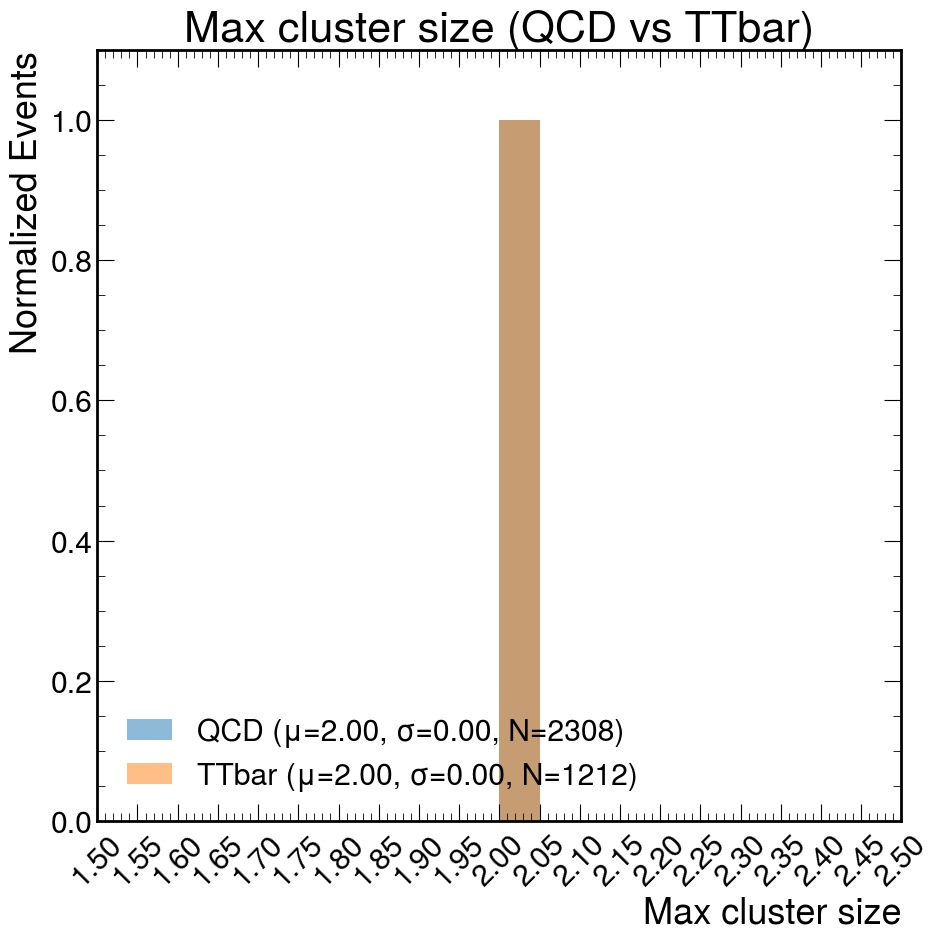

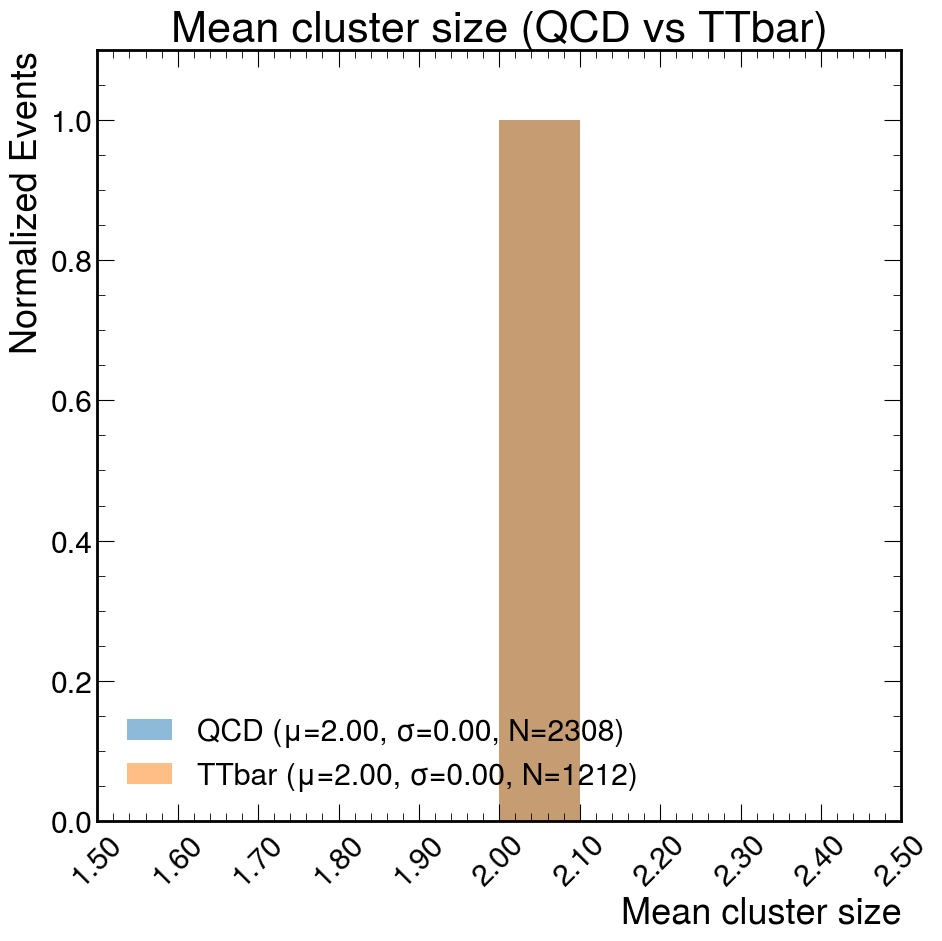

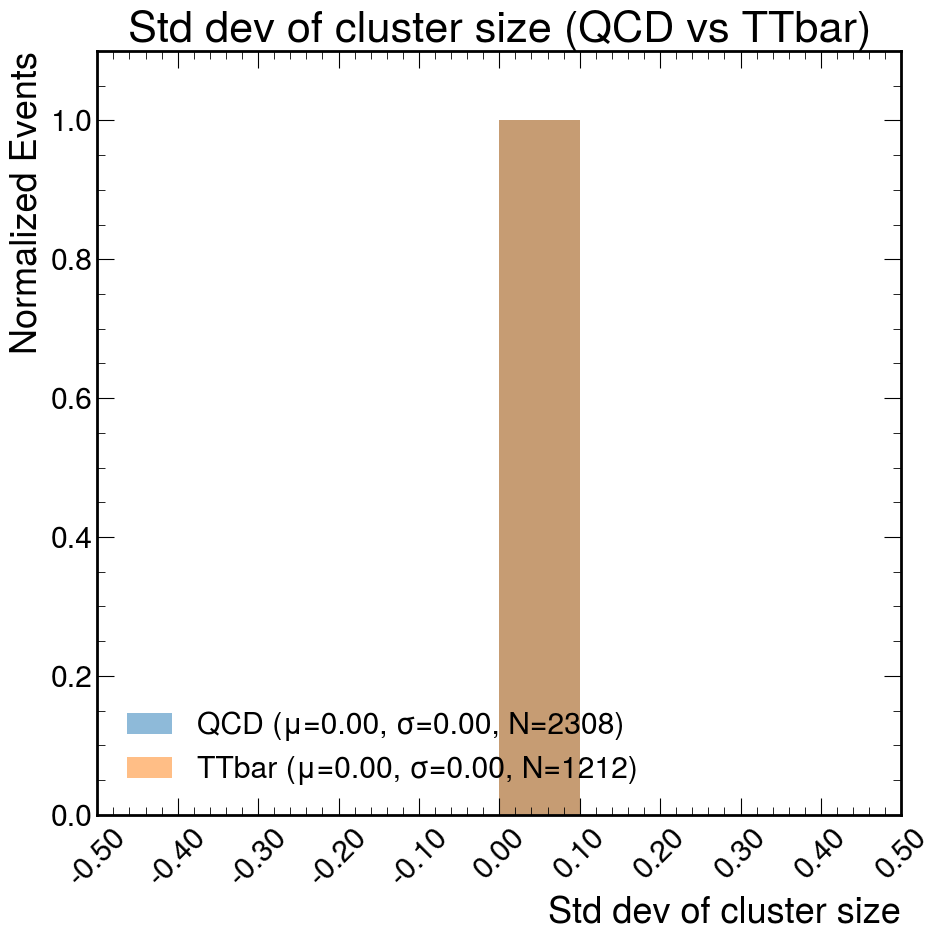

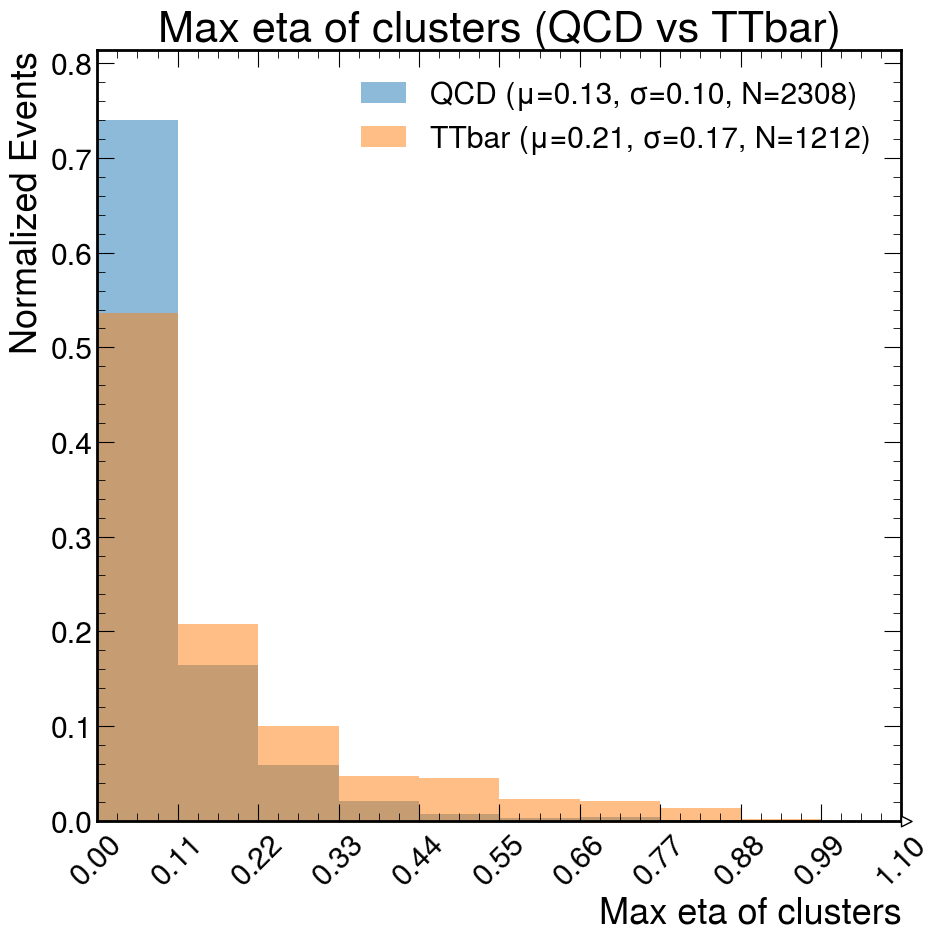

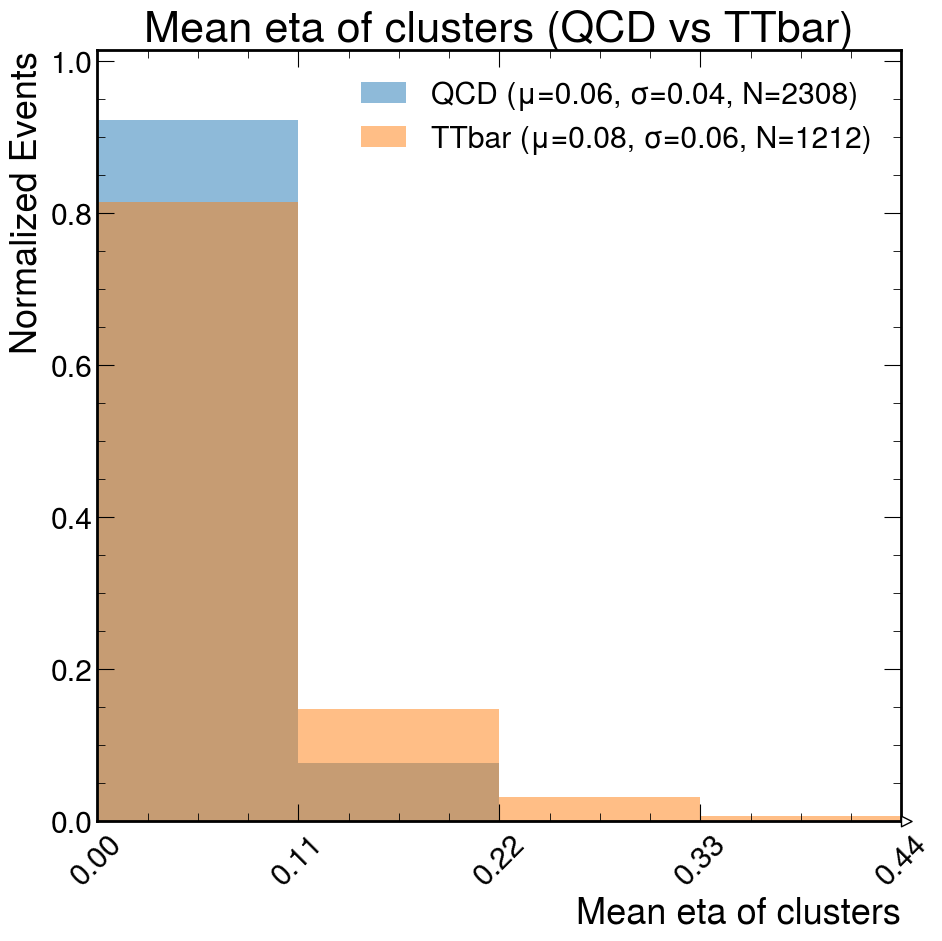

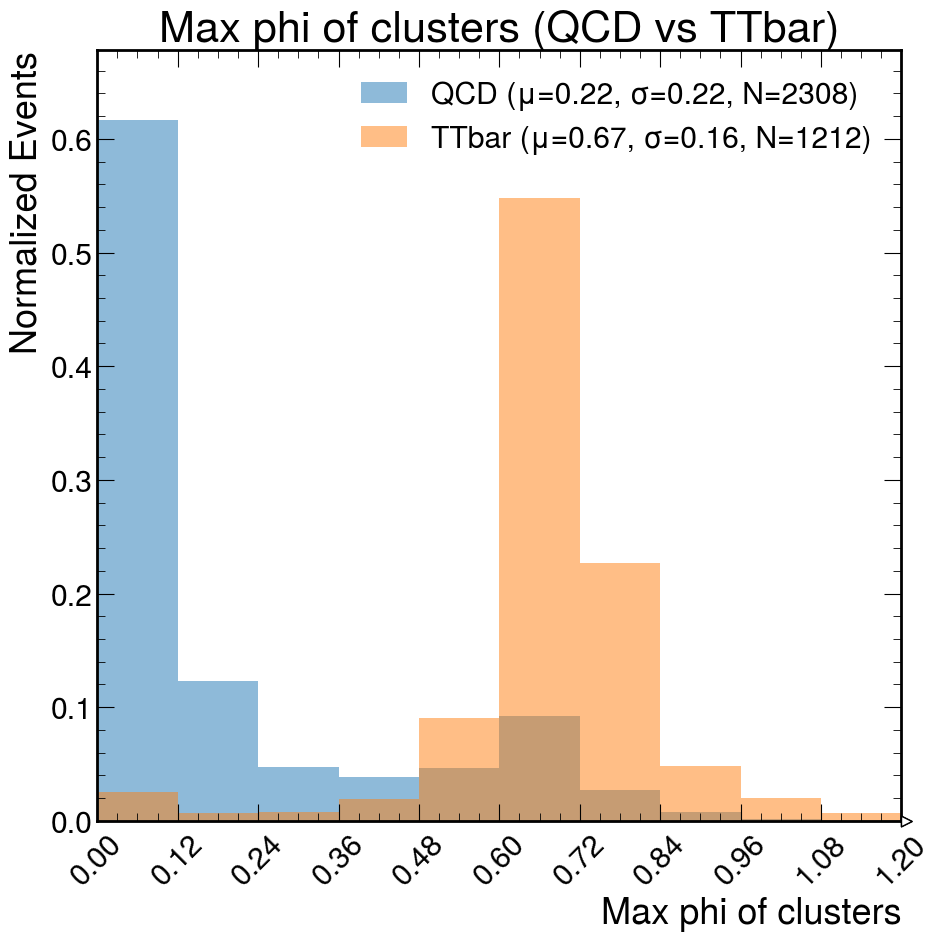

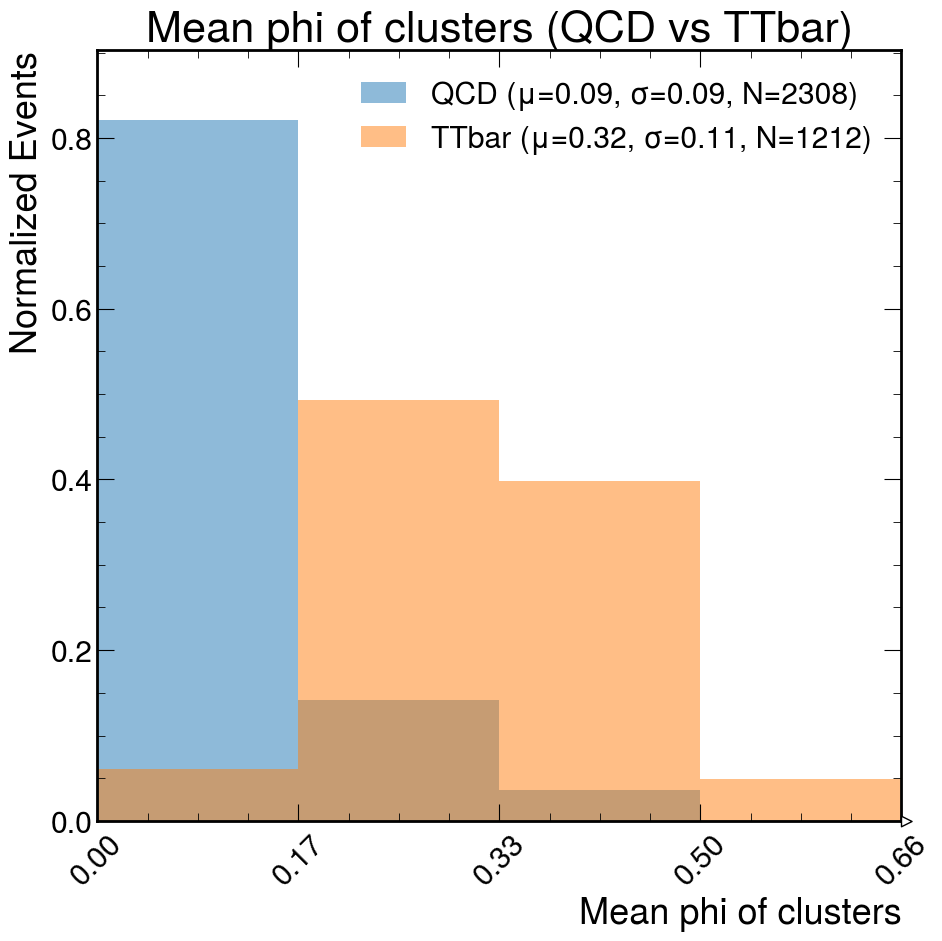

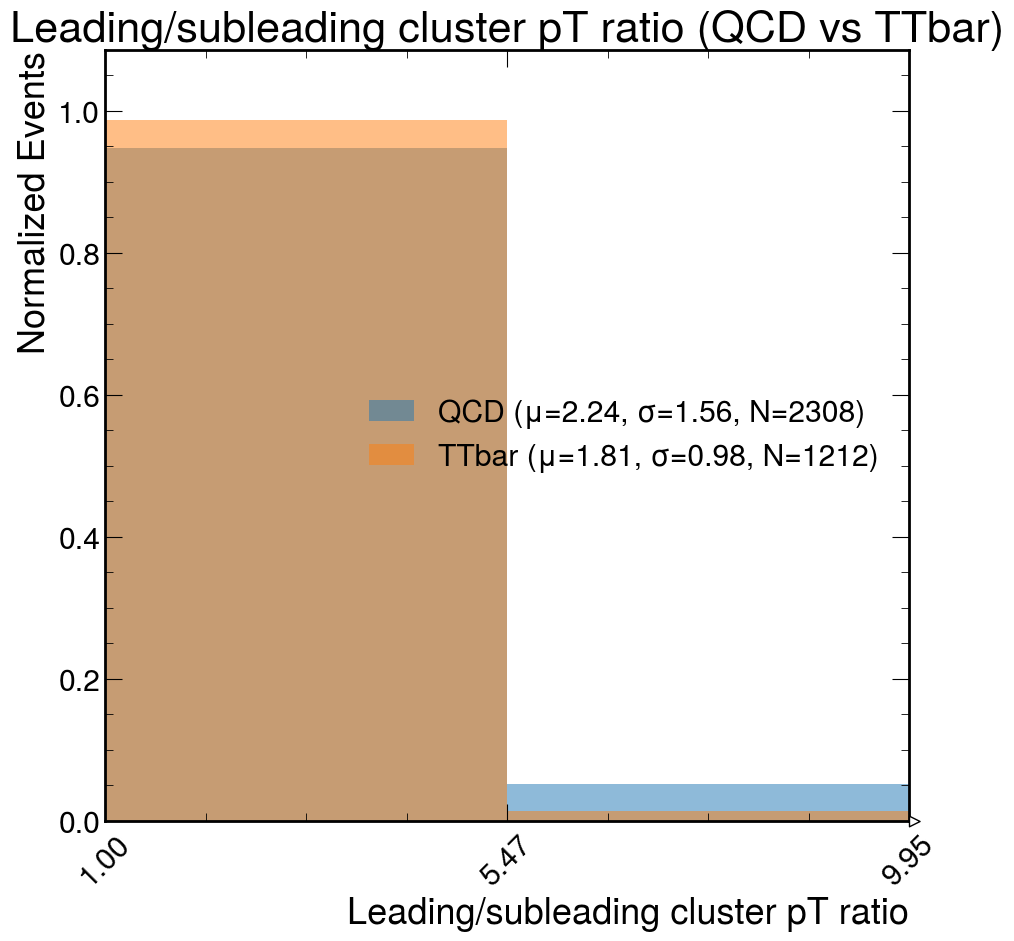

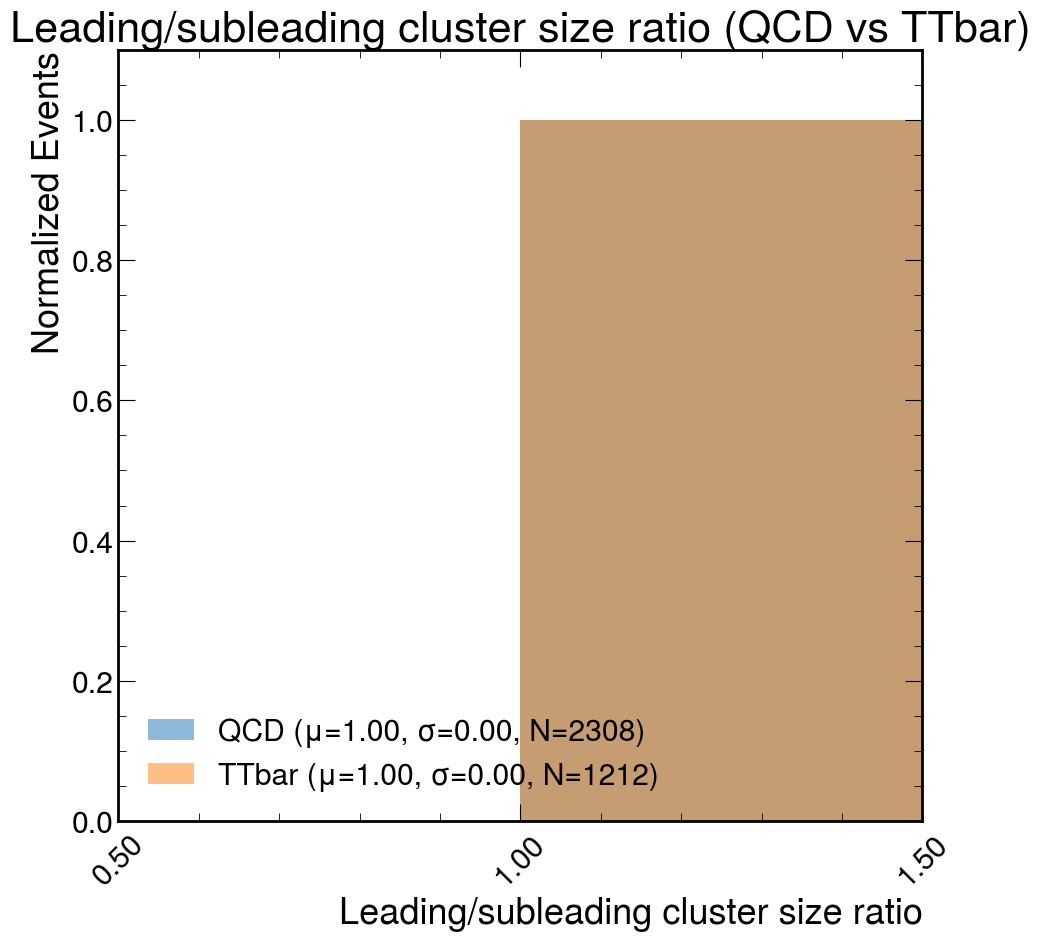

In [5]:
for var, (label, _) in features.items():  
    if var in features_df.columns:
        plot_variable(var, label) 
    else:
        print(f"[WARNING] {var} not found in CSV columns.")

## 1. Load and Prepare Data

We will create the graphs from images, but there are many other ways to do it. 

The energy deposited in a pixel will be the node feature, and we will connect each pixel to its eight closest pixels (up, down, sides, diagonals). 

The graph building function written here has an option to set max_nodes, which will only choose the top n most energetic nodes. There's also an option whether to consider all nodes or not, if you set this to false, it will throw away all the pixels with 0 energy deposited. 

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from jet_utils import load_images
from jet_gnn_utils import create_graph_data
from jet_plotting_utils import plot_confusion_matrix, plot_training_history, plot_roc_curve

In [7]:
# Load data
X_train, y_train, train_ids, X_val, y_val, val_ids, X_test, test_ids = load_images()
# Convert to graph format - this might take a bit of time to run
X_train_graphs = create_graph_data(X_train, y_train, max_nodes=900, consider_all_nodes=True)
X_val_graphs = create_graph_data(X_val, y_val, max_nodes=900)
X_test_graphs = create_graph_data(X_test, max_nodes=900)

Created 3520 graphs
Average number of nodes: 900.0
Average number of edges: 7332.0
Created 502 graphs
Average number of nodes: 900.0
Average number of edges: 7332.0
Created 1005 graphs
Average number of nodes: 900.0
Average number of edges: 7332.0


## 2. Build GNN Model

We'll create a GNN with:
- Graph Convolutional layers to learn from node features and graph structure
- Global pooling to get graph-level representations
- Dense layers for classification

In [8]:
class GNN(nn.Module):
    def __init__(self, num_features):
        super(GNN, self).__init__()
        # Graph convolution layers
        self.conv1 = GCNConv(num_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.conv3 = GCNConv(64, 64)

        
        # Dense layers
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Graph convolution layers
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        
        # Global pooling
        x = global_mean_pool(x, batch)
        
        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        #x = self.fc2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x #torch.sigmoid(x)

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GNN(num_features=1).to(device)  # 4 features: pt, eta, phi, charge
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss() #nn.BCELoss()


In [9]:
train_loader = DataLoader(X_train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(X_val_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(X_test_graphs, batch_size=32)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## 3. Train Model

We'll train the GNN with:
- Adam optimizer
- Binary Cross Entropy loss
- Early stopping based on validation accuracy


You'll see this code differs a fair bit from the previous DNN and CNN. This is because we're using pytorch geometric -  the most common GNN package. It integrates with Pytorch, so we are using Pytorch instead of keras. Torch is growing to be the most popular ML libary, but keras is easier to learn. 

You might also see that training on CPU this is a lot slower than the other ML methods. Can you explain why? 

In [10]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.to(device))
        loss = criterion(out, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.to(device))
        loss = criterion(out, data.y.view(-1, 1))
        pred = (out > 0.5).float()
        correct += int((pred == data.y.view(-1, 1)).sum())
    return correct / len(loader.dataset), loss


history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}


# Training loop
best_acc = 0
for epoch in range(70):
    loss = train()
    train_acc = test(train_loader)[0]
    val_acc, val_loss = test(val_loader)
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')


    # Append to history
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)

Epoch 000, Loss: 0.6544, Train Acc: 0.6557, Val Acc: 0.6633
Epoch 001, Loss: 0.6378, Train Acc: 0.6557, Val Acc: 0.6633
Epoch 002, Loss: 0.5886, Train Acc: 0.6557, Val Acc: 0.6633
Epoch 003, Loss: 0.5620, Train Acc: 0.6540, Val Acc: 0.6614
Epoch 004, Loss: 0.5571, Train Acc: 0.6554, Val Acc: 0.6633
Epoch 005, Loss: 0.5403, Train Acc: 0.6551, Val Acc: 0.6633
Epoch 006, Loss: 0.5347, Train Acc: 0.6557, Val Acc: 0.6633
Epoch 007, Loss: 0.5165, Train Acc: 0.6557, Val Acc: 0.6614
Epoch 008, Loss: 0.5052, Train Acc: 0.6670, Val Acc: 0.6653
Epoch 009, Loss: 0.4408, Train Acc: 0.7810, Val Acc: 0.7829
Epoch 010, Loss: 0.3897, Train Acc: 0.8690, Val Acc: 0.8606
Epoch 011, Loss: 0.3583, Train Acc: 0.8693, Val Acc: 0.8526
Epoch 012, Loss: 0.3520, Train Acc: 0.8841, Val Acc: 0.8705
Epoch 013, Loss: 0.3272, Train Acc: 0.8847, Val Acc: 0.8725
Epoch 014, Loss: 0.3252, Train Acc: 0.8557, Val Acc: 0.8606
Epoch 015, Loss: 0.3269, Train Acc: 0.8920, Val Acc: 0.8845
Epoch 016, Loss: 0.3210, Train Acc: 0.88

## 4. Evaluate Model

Let's evaluate our model's performance on the test set.

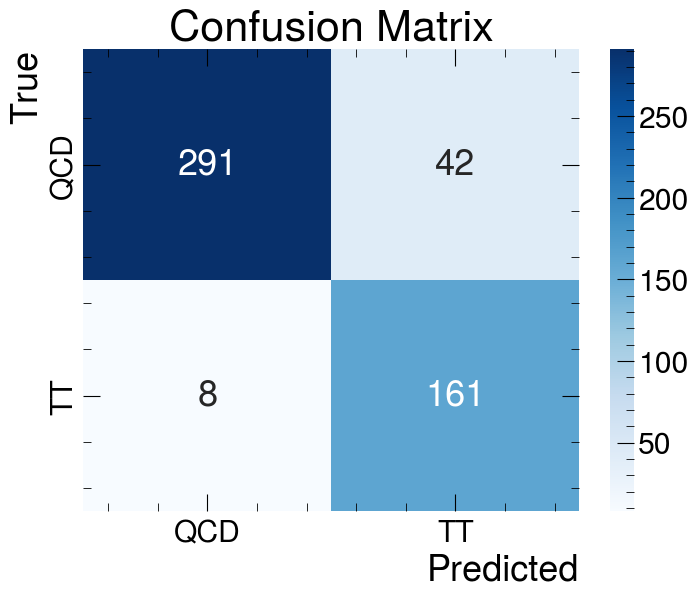

In [11]:
# Load best model
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad(): 
    for data in val_loader:
        out = model(data.to(device))
        y_true.extend(data.to('cpu').y.numpy())
        y_pred.extend(out.to('cpu').numpy())

y_pred = np.array([x[0] for x in y_pred])
pred_discrete = np.where(y_pred > 0.5, 1, 0)
# Plot confusion matrix
plot_confusion_matrix(y_true, pred_discrete)

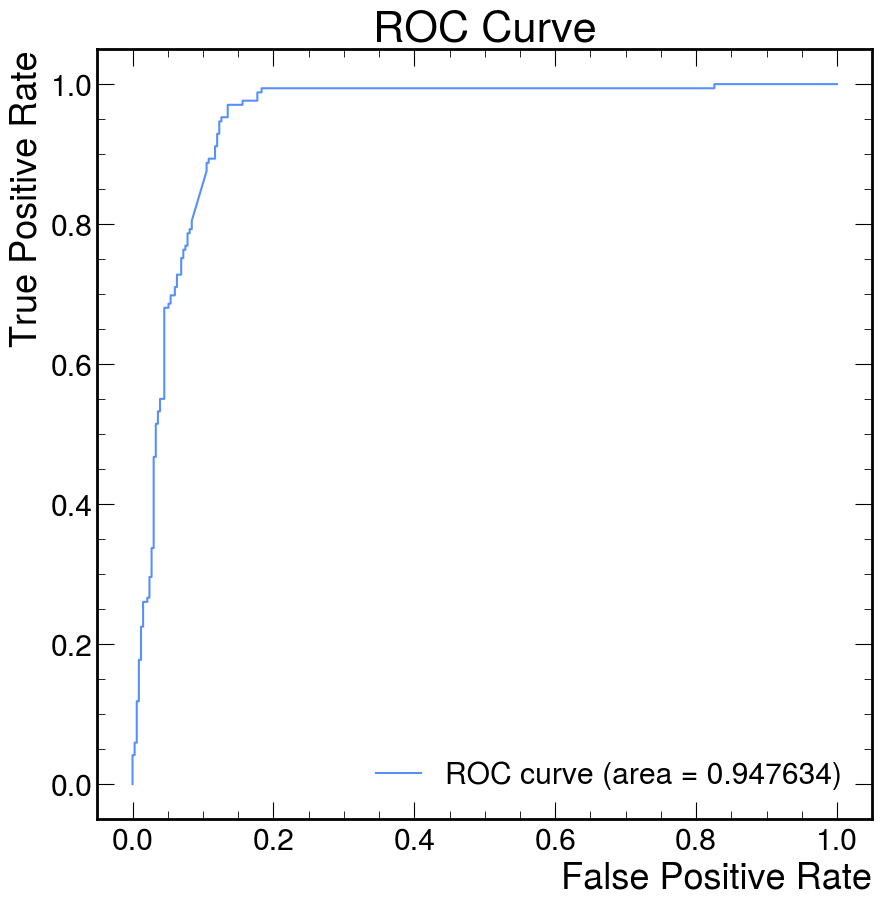

In [12]:
plot_roc_curve(y_true, y_pred)

# 5 - Making predictions

In [13]:
y_pred_test = []
for data in test_loader:
    with torch.no_grad():
        output = model(data.to(device))
        # could you change the prediction threshold? Would that make it better?
        y_pred_test.extend(output.to('cpu').numpy())

y_pred_test = np.array([x[0] for x in y_pred_test])


In [14]:
import pandas as pd
solution = pd.DataFrame({'id':test_ids, 'label':y_pred_test})
solution.to_csv('submission.csv', index=False)